### ViT VQ-GAN trained on ImageNet

In [3]:
import paintmind as pm
from PIL import Image
import glob
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")

/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [4]:
images = glob.glob("/mnt/SSD1/Niantic/data/test/**/**/*.jpg")
seed_number = 48 
random.seed(seed_number)
random.shuffle(images)
selected_images = images[:5]

In [40]:
model = pm.create_model(arch='vqgan', version='vit-s-vqgan', pretrained=True, checkpoint_path='/mnt/SSD1/Niantic/tokenizers/RGB/vit.pt')
tensor_outputs = []
for image in tqdm(selected_images):
    img = Image.open(image).convert('RGB')
    img = pm.stage1_transform(is_train=False)(img)
    z, _, _ = model.encode(img.unsqueeze(0))
    rec = model.decode(z).squeeze(0)
    rec = torch.clamp(rec, -1., 1.)
    tensor_outputs.append(rec)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


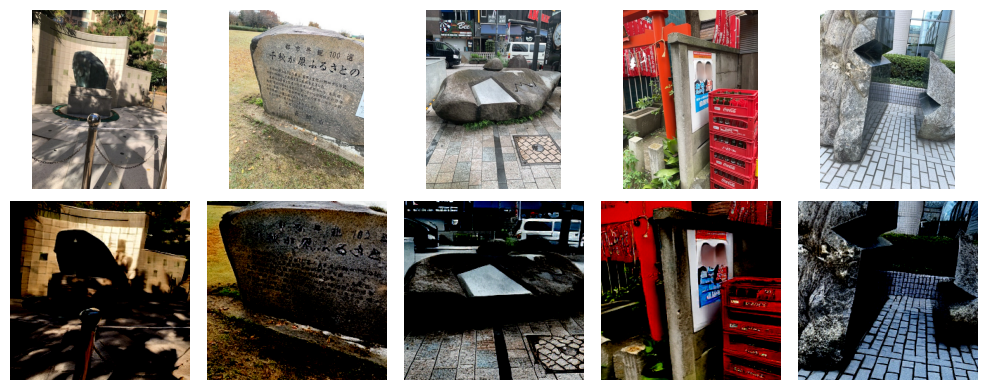

In [41]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(tensor_outputs):
    tensor = torch.clamp(tensor, 0, 1)
    axs[1, i].imshow(tensor.permute(1, 2, 0).detach().numpy())
    axs[1, i].axis('off')
plt.tight_layout() 
plt.show()

### ml-4M RGB Tokenizer

In [1]:
from fourm.vq.vqvae import DiVAE
from PIL import Image
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hitesh/dualmapfree/4M_dataset_dev/ml-4m/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/hitesh/dualmapfree/4M_dataset_dev/ml-4m/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available


INFO:datasets:PyTorch version 2.4.0 available.


In [2]:
tok = DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_rgb_16k_224-448').cuda()
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN, std=IMAGENET_INCEPTION_STD)

In [9]:
tensors_b3hw = []
for image_path in selected_images :
    image = Image.open(image_path).convert('RGB')  
    rgb_b3hw = transform(resize(image)).unsqueeze(0)  
    tensors_b3hw.append(rgb_b3hw)
stacked_tensors_b3hw = torch.cat(tensors_b3hw, dim=0)
_, _, tokens = tok.encode(normalize(stacked_tensors_b3hw).cuda())
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw  = tok.decode_tokens(tokens, image_size=image_size)
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN, std=IMAGENET_INCEPTION_STD)

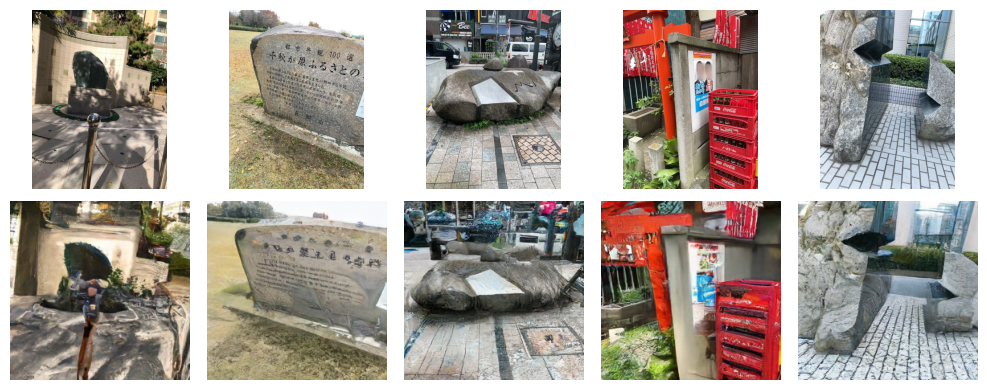

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    tensor = torch.clamp(tensor, 0, 1)
    axs[1, i].imshow(tensor.cpu().permute(1, 2, 0).detach().numpy())
    axs[1, i].axis('off')
plt.tight_layout() 
plt.show()